In [1]:
# This is the project code.

In [1]:
import pyspark
from delta import *

builder = pyspark.sql.SparkSession.builder.appName("DF2_Practice") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") 

spark = configure_spark_with_delta_pip(builder).getOrCreate()

spark.conf.set("spark.sql.repl.eagerEval.enabled",True) # OK for exploration, not great for performance
spark.conf.set("spark.sql.repl.eagerEval.truncate", 500)

In [44]:
import pandas as pd
import json
import numpy as np
import shapely
from shapely import Point
from shapely.geometry import mapping, shape
import pyspark.sql.functions as F
from pyspark.sql import Window
from shapely import Polygon
from pyspark.sql.functions import col, count, when
from pyspark.sql.types import DoubleType, IntegerType, StringType
from shapely.strtree import STRtree
import matplotlib.pyplot as plt

## Reading in data

In [3]:
# Reading in taxi dataset
taxiDataDf = (spark.read
             .option("sep", ",") # separator
             .option("header", True) # file has header row
             .option("inferSchema", True) # spark tries to infer data types
             .csv("sample.csv") #path
            )

In [4]:
display(taxiDataDf)

medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.0,-73.978165,40.757977,-73.989838,40.751171
0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.5,-74.006683,40.731781,-73.994499,40.75066
0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.1,-74.004707,40.73777,-74.009834,40.726002
DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.7,-73.974602,40.759945,-73.984734,40.759388
DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.1,-73.97625,40.748528,-74.002586,40.747868
20D9ECB2CA0767CF7A01564DF2844A3E,598CCE5B9C1918568DEE71F43CF26CD2,CMT,1,N,2013-01-07 15:27:48,2013-01-07 15:38:37,1,648,1.7,-73.966743,40.764252,-73.983322,40.743763
496644932DF3932605C22C7926FF0FE0,513189AD756FF14FE670D10B92FAF04C,CMT,1,N,2013-01-08 11:01:15,2013-01-08 11:08:14,1,418,0.8,-73.995804,40.743977,-74.007416,40.744343
0B57B9633A2FECD3D3B1944AFC7471CF,CCD4367B417ED6634D986F573A552A62,CMT,1,N,2013-01-07 12:39:18,2013-01-07 13:10:56,3,1898,10.7,-73.989937,40.756775,-73.86525,40.77063
2C0E91FF20A856C891483ED63589F982,1DA2F6543A62B8ED934771661A9D2FA0,CMT,1,N,2013-01-07 18:15:47,2013-01-07 18:20:47,1,299,0.8,-73.980072,40.743137,-73.982712,40.735336
2D4B95E2FA7B2E85118EC5CA4570FA58,CD2F522EEE1FF5F5A8D8B679E23576B3,CMT,1,N,2013-01-07 15:33:28,2013-01-07 15:49:26,2,957,2.5,-73.977936,40.786983,-73.952919,40.80637


In [5]:
# Reading in borough dataset
with open('nyc-boroughs.geojson') as file:
    boroughs = json.load(file)

features = boroughs['features']
properties = [feature['properties'] for feature in features]
geometry = [feature['geometry'] for feature in features]

rowNumberWindow = Window.orderBy(F.lit("a"))

properties_df = spark.createDataFrame(properties).withColumn("rid",F.row_number().over(rowNumberWindow))
geometry_df = spark.createDataFrame(geometry).withColumn("rid",F.row_number().over(rowNumberWindow))
borough_base_df = properties_df.join(geometry_df,("rid")).drop("rid") #rid - row_id

In [6]:
display(borough_base_df)

@id,borough,boroughCode,coordinates,type
http://nyc.pediacities.com/Resource/Borough/Staten_Island,Staten Island,5,"[[[-74.05050806403247, 40.566422034160816], [-74.04998352562575, 40.56639592492827], [-74.04931640362088, 40.56588774778044], [-74.04923629842045, 40.5653627363681], [-74.05002620158643, 40.565318180621134], [-74.05090601705089, 40.5660943421306], [-74.05067916748614, 40.5663108457364], [-74.05107159803778, 40.5667224933978], [-74.05050806403247, 40.566422034160816]]]",Polygon
http://nyc.pediacities.com/Resource/Borough/Staten_Island,Staten Island,5,"[[[-74.05314036821109, 40.577702715545755], [-74.05406044939875, 40.57711644523887], [-74.05489778210804, 40.57778244091981], [-74.05469316907487, 40.579691632229434], [-74.05485134625391, 40.57970759307761], [-74.05484560052174, 40.579945791427605], [-74.05368629150419, 40.58054875961441], [-74.05293190639817, 40.57990247466585], [-74.05314036821109, 40.577702715545755]]]",Polygon
http://nyc.pediacities.com/Resource/Borough/Staten_Island,Staten Island,5,"[[[-74.15945602438188, 40.641448333324036], [-74.15997875699617, 40.64144648083637], [-74.16111242522175, 40.641835453737215], [-74.16146036005294, 40.644294969764864], [-74.15798759540647, 40.64386178896607], [-74.1574334920099, 40.643302857779005], [-74.15791589406767, 40.64308269445278], [-74.15813451603348, 40.642632530662986], [-74.15855043770541, 40.642497501306394], [-74.15881093745297, 40.64175863474031], [-74.15945602438188, 40.641448333324036]]]",Polygon
http://nyc.pediacities.com/Resource/Borough/Staten_Island,Staten Island,5,"[[[-74.08221272914938, 40.64828016229008], [-74.08142228203805, 40.64850472594939], [-74.08072838762374, 40.64827487384626], [-74.07980996428705, 40.648383312987924], [-74.07899546333259, 40.648142554422414], [-74.0765065715286, 40.646968818183346], [-74.074452825637, 40.645067488723235], [-74.07395839976468, 40.645193205445516], [-74.07359107919278, 40.64499892804299], [-74.07349851367621, 40.6450833734751], [-74.07385653684726, 40.645424816099606], [-74.07333813856985, 40.64578311616224], [...",Polygon
http://nyc.pediacities.com/Resource/Borough/Queens,Queens,4,"[[[-73.83668274106708, 40.59494669701581], [-73.83670920760008, 40.59471196329251], [-73.83624456552003, 40.59449639775509], [-73.83527199389951, 40.59447351751445], [-73.83511720319443, 40.594365843590154], [-73.8351134853272, 40.59396826505302], [-73.8343321268489, 40.593660767746755], [-73.83422463139404, 40.593348241995784], [-73.83361163952571, 40.59327751230231], [-73.83329545012084, 40.59289022545184], [-73.83308377330326, 40.59298662645058], [-73.83312434323058, 40.592264070070016], [...",Polygon
http://nyc.pediacities.com/Resource/Borough/Queens,Queens,4,"[[[-73.8133966522335, 40.60436407224537], [-73.81184130264798, 40.60313466508569], [-73.81085365186652, 40.603223713014266], [-73.81053636758675, 40.602495988814695], [-73.80986333857174, 40.60189579000784], [-73.81003425937602, 40.60161090846043], [-73.809912581666, 40.60132020993275], [-73.8100429323135, 40.600954710545174], [-73.80985064502396, 40.60036561675854], [-73.81000132948448, 40.60002868281523], [-73.81014417523032, 40.60005485564217], [-73.80997465251744, 40.59983670280389], [-73...",Polygon
http://nyc.pediacities.com/Resource/Borough/Queens,Queens,4,"[[[-73.82718282107055, 40.60791977809121], [-73.82679537497147, 40.60772044059308], [-73.8262976301582, 40.60781707222969], [-73.82617361009878, 40.607554111782314], [-73.82639117752834, 40.607357433651224], [-73.82598212776459, 40.60715799759936], [-73.82590092720773, 40.60646593064943], [-73.8264961879578, 40.60622446371774], [-73.82690524584686, 40.60642389797726], [-73.82861671457664, 40.605838484137564], [-73.82866060090227, 40.60625615837476], [-73.82815085191218, 40.607950289832964], [...",Polygon
http://nyc.pediacities.com/Resource/Borough/Queens,Queens,4,"[[[-73.82607472604549, 40.60843779954608], [-73.82661051008792, 40.60819620584166], [-73.82771104235995, 40.608398668130675], [-73.8280507726

In [7]:
# Finding the area size of the boroughs
def calculate_area(coordinates):
    polygon = Polygon(list(coordinates[0]))
    return polygon.area

calculate_area_udf = F.udf(calculate_area,DoubleType())

borough_df_sorted = borough_base_df.withColumn("area",calculate_area_udf(F.col("coordinates"))) \
                            .sort(F.col("area").desc()) \
                            .withColumn("row_id",F.row_number().over(rowNumberWindow) - 1)

# https://shapely.readthedocs.io/en/stable/strtree.html
geomtree = STRtree([Polygon(coords["coordinates"][0]) for coords in borough_df_sorted.select("coordinates").collect()])
borough_df_sorted

@id,borough,boroughCode,coordinates,type,area,row_id
http://nyc.pediacities.com/Resource/Borough/Queens,Queens,4,"[[[-73.89145055584646, 40.776372179016676], [-73.89145185712489, 40.776512769270866], [-73.8911204433948, 40.777124699736], [-73.8905625059536, 40.77740392096429], [-73.89035193082614, 40.77780032027483], [-73.89008729416801, 40.77778419360687], [-73.88947105399761, 40.77553555096723], [-73.88978900756067, 40.77423686116983], [-73.89019171520673, 40.77364687622498], [-73.88985169959679, 40.77375329736393], [-73.88945486903738, 40.773532951127166], [-73.8858076228666, 40.774022224475374], [-73...",Polygon,0.02719387322630712,0
http://nyc.pediacities.com/Resource/Borough/Brooklyn,Brooklyn,3,"[[[-73.95439555417089, 40.739114772522505], [-73.95198794354425, 40.73874762097681], [-73.94652352854787, 40.73692685395815], [-73.94645392267348, 40.73680959046116], [-73.9471998336712, 40.73535517811413], [-73.94706532915389, 40.73440199281923], [-73.94659806707354, 40.734442224347276], [-73.946736923407, 40.735294943719836], [-73.94692902737472, 40.735313140683736], [-73.94662663786626, 40.73586558516741], [-73.94644310074186, 40.7358131844557], [-73.94617195881511, 40.73620288877423], [-7...",Polygon,0.01870558901900347,1
http://nyc.pediacities.com/Resource/Borough/Staten_Island,Staten Island,5,"[[[-74.08221272914938, 40.64828016229008], [-74.08142228203805, 40.64850472594939], [-74.08072838762374, 40.64827487384626], [-74.07980996428705, 40.648383312987924], [-74.07899546333259, 40.648142554422414], [-74.0765065715286, 40.646968818183346], [-74.074452825637, 40.645067488723235], [-74.07395839976468, 40.645193205445516], [-74.07359107919278, 40.64499892804299], [-74.07349851367621, 40.6450833734751], [-74.07385653684726, 40.645424816099606], [-74.07333813856985, 40.64578311616224], [...",Polygon,0.01603547601912208,2
http://nyc.pediacities.com/Resource/Borough/Bronx,Bronx,2,"[[[-73.87294860352858, 40.90444102266826], [-73.85946778700769, 40.90051720926688], [-73.85907692341046, 40.90100799310065], [-73.85941984091325, 40.90139312501249], [-73.85937696525053, 40.90156521816433], [-73.85902704152225, 40.90144490975347], [-73.85886401316355, 40.90171169504956], [-73.85946389958121, 40.90193387763358], [-73.85957882948261, 40.902440842771384], [-73.85926432541882, 40.902669479896545], [-73.8587282483346, 40.9022889705702], [-73.85816000004857, 40.902305710202725], [-...",Polygon,0.011405869460254603,3
http://nyc.pediacities.com/Resource/Borough/Manhattan,Manhattan,1,"[[[-73.92640556921117, 40.87762147653734], [-73.92629548795446, 40.87748846858917], [-73.92645784900961, 40.877258189008735], [-73.92619292267656, 40.877064419414374], [-73.92555292248268, 40.87710258898463], [-73.92508215701339, 40.87739761061557], [-73.92457036990588, 40.877428912671306], [-73.92329476733927, 40.87726443545978], [-73.92239768169318, 40.876780223141196], [-73.92244468226002, 40.87569183576377], [-73.9226680400197, 40.874981991369474], [-73.92261383040437, 40.87440727210196],...",Polygon,0.005859077996035753,4
http://nyc.pediacities.com/Resource/Borough/Queens,Queens,4,"[[[-73.8049919885511, 40.5967523588775], [-73.80487565214918, 40.59674853593164], [-73.80511185479914, 40.597151047998096], [-73.8047111222805, 40.597674663195114], [-73.80393338922406, 40.597943498583916], [-73.80297943325749, 40.59884430455297], [-73.80167092680179, 40.59889630926943], [-73.80094867862822, 40.59915166461987], [-73.80091500623968, 40.59939076113576], [-73.80077654707625, 40.599162360478296], [-73.8004952637198, 40.599204368068555], [-73.80047379227797, 40.59933155912372], [-...",Polygon,0.002244027128579165,5
http://nyc.pediacities.com/Resource/Borough/Queens,Queens,4,"[[[-73.82337592129355, 40.638987655897566], [-73.82277105438688, 40.635576914085036], [-73.82209868083655, 40.6340723011468], [-73.82184604252807, 40.63204018843733], [-73.82107505533322, 40.6297337745662], [-73.81991014068154, 40.62784065311699], [-73.8179641483957, 40.62710556569674], [-73.8180075222

In [8]:
def findBorough(x,y):
    point = Point(x,y)
    nearestLocIndex = geomtree.nearest(point)
    return nearestLocIndex

In [9]:

# Define a function to find the point borough
def update_borough(longitude, latitude):
    borough = findBorough(longitude, latitude)
    return int(borough) if borough is not None else -1

# Create a user-defined function (UDF)
update_borough_udf = F.udf(update_borough, IntegerType())

# Apply the UDF to update the start and end borough column (finding the borough index)
taxiDataDf_with_boroughs = taxiDataDf.withColumn("startBoroughIndex", update_borough_udf(taxiDataDf["pickup_longitude"], taxiDataDf["pickup_latitude"]))
taxiDataDf_with_boroughs = taxiDataDf_with_boroughs.withColumn("endBoroughIndex", update_borough_udf(taxiDataDf["dropoff_longitude"], taxiDataDf["dropoff_latitude"]))

In [10]:
taxiDataDf_with_boroughs.groupBy("startBoroughIndex").count().orderBy("startBoroughIndex")

startBoroughIndex,count
0,5957
1,1970
2,22
3,89
4,90156
5,1751
7,5
17,19
22,2
26,1


## Query 1: Utilization

Utilization: This is per taxi/driver. This can be computed by computing the idle 
time per taxi. We will elaborate on that more later

In [11]:
taxiUtilizationBaseDf = taxiDataDf_with_boroughs.filter("trip_time_in_secs > 0 or trip_time_in_secs <= 3600 * 4")
              

utilizationWindow = Window.partitionBy("hack_license").orderBy("pickup_datetime")

idleTimeDf = taxiUtilizationBaseDf.withColumn("idle_time",(F.col("pickup_datetime") - F.lag(F.col("dropoff_datetime")).over(utilizationWindow)).cast("long")) \
                                  .fillna(0,subset=["idle_time"])
display(idleTimeDf)

medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,startBoroughIndex,endBoroughIndex,idle_time
0E05D2A5CCFCA4AA81B3E6772632CA08,008BE4F3FF93935048998BB183D27263,VTS,1,NULL,2013-01-13 02:36:00,2013-01-13 02:42:00,5,360,1.1,-73.983185,40.738731,-73.9944,40.746029,4,4,0
CA853C09FCD9FE8D830096584392D1AA,00927C48BA4C1B2B1B6403B8BFE1AB03,VTS,1,NULL,2013-01-13 10:07:00,2013-01-13 10:25:00,5,1080,1.87,-73.930962,40.738007,-73.930962,40.738007,0,0,0
CA853C09FCD9FE8D830096584392D1AA,00927C48BA4C1B2B1B6403B8BFE1AB03,VTS,1,NULL,2013-01-13 10:42:00,2013-01-13 11:01:00,5,1140,3.9,-73.930962,40.738007,-73.930962,40.738007,0,0,1020
CA853C09FCD9FE8D830096584392D1AA,00927C48BA4C1B2B1B6403B8BFE1AB03,VTS,1,NULL,2013-01-13 11:29:00,2013-01-13 11:42:00,5,780,4.25,-73.930962,40.738007,-73.930962,40.738007,0,0,1680
CA853C09FCD9FE8D830096584392D1AA,00927C48BA4C1B2B1B6403B8BFE1AB03,VTS,1,NULL,2013-01-13 11:43:00,2013-01-13 11:58:00,5,900,4.83,-73.930962,40.738007,-73.930962,40.738007,0,0,60
CA853C09FCD9FE8D830096584392D1AA,00927C48BA4C1B2B1B6403B8BFE1AB03,VTS,1,NULL,2013-01-13 12:00:00,2013-01-13 12:08:00,5,480,1.3,-73.930962,40.738007,-73.995804,40.7169,0,4,120
CA853C09FCD9FE8D830096584392D1AA,00927C48BA4C1B2B1B6403B8BFE1AB03,VTS,1,NULL,2013-01-13 12:14:00,2013-01-13 12:22:00,5,480,1.14,-73.99839,40.713715,-73.996864,40.72543,4,4,360
CA853C09FCD9FE8D830096584392D1AA,00927C48BA4C1B2B1B6403B8BFE1AB03,VTS,1,NULL,2013-01-13 12:24:00,2013-01-13 12:35:00,5,660,3.32,-73.996864,40.72543,-74.004189,40.725327,4,4,120
CA853C09FCD9FE8D830096584392D1AA,00927C48BA4C1B2B1B6403B8BFE1AB03,VTS,1,NULL,2013-01-13 12:42:00,2013-01-13 12:50:00,5,480,1.96,-73.979401,40.776546,-73.977989,40.760052,4,4,420
CA853C09FCD9FE8D830096584392D1AA,00927C48BA4C1B2B1B6403B8BFE1AB03,VTS,1,NULL,2013-01-13 14:00:00,2013-01-13 14:02:00,5,120,0.61,-73.994926,40.761173,-73.994926,40.761173,4,4,4200


In [12]:
query1_df = idleTimeDf.groupBy("hack_license").agg(F.sum("idle_time").alias("idle_time_sum_seconds"))
display(query1_df)

hack_license,idle_time_sum_seconds
001C8AAB90AEE49F36FCAA7B4136C81A,864180
0025133AD810DBE80D35FCA8BF0BCA1F,2400
00447A6197DBB329FBF764139ACA6EC4,13440
006313464EC98A24BB4EBC1E2419E439,31500
007439EEDB510EF8277C567BD200B08F,3240
008BE4F3FF93935048998BB183D27263,0
00927C48BA4C1B2B1B6403B8BFE1AB03,14460
00AE05F56D451E89E6F83EBE384FF5E6,22200
00B442110FA2D04A167DB0C9E7C73545,10680
00B938EAB7C933C9B6F30F95D72DAFEB,0


In [13]:
#Save result to file
query1_df.coalesce(1).write.mode("overwrite").csv("results/query1.csv",header=True)

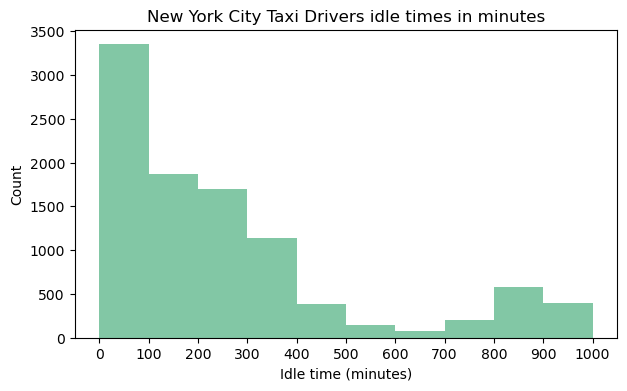

In [93]:
# Plotting the results

pandas_query1_df = query1_df.toPandas()
idle_time = pandas_query1_df.get("idle_time_sum_seconds")
idle_time_minutes = [ int(x/60) for x in idle_time]

# NB! Over 1000 minutes is missing!!!
fig = plt.figure(figsize = (7, 4))

bins= [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000] # NB! Over 1000 minutes values are missing!!!
plt.hist(idle_time_minutes, bins=bins, color="#82c7a5ff")
plt.xticks(bins)
plt.xlabel("Idle time (minutes)")
plt.ylabel("Count")
plt.title("New York City Taxi Drivers idle times in minutes")

plt.show()

In [98]:
# There are 149 values that are more than 1000 minutes and that are not represented in the graph.
more_1000 = 0
for i in range(len(idle_time_minutes)):
    if idle_time_minutes[i] > 1000:
        more_1000 += 1
print(more_1000)

149


## Query 2: Average next trip time

The average time it takes for a taxi to find its next fare(trip) per destination borough. This can be computed by finding the time difference, e.g. in seconds, between the trip's drop off and the next trip's pick up.


In [46]:
from pyspark.sql.functions import col, unix_timestamp, lead, avg, round

windowSpec = Window.partitionBy("hack_license").orderBy("dropoff_datetime")

df = taxiDataDf_with_boroughs.withColumn("next_pickup_time", lead("pickup_datetime").over(windowSpec))
df = df.withColumn("time_to_next_fare", unix_timestamp("next_pickup_time") - unix_timestamp("dropoff_datetime"))
df = df.filter((col("time_to_next_fare") >= 0) & (col("time_to_next_fare") <= 3600*4))  

result_df = df.join(borough_df_sorted, df.endBoroughIndex == borough_df_sorted.row_id)
avg_wait_time_per_borough = result_df.groupBy("borough").agg(round(avg("time_to_next_fare") / 60 , 2).alias("avg_waiting_time"))

avg_wait_time_per_borough.show()

+-------------+----------------+
|      borough|avg_waiting_time|
+-------------+----------------+
|       Queens|           38.17|
|     Brooklyn|           34.58|
|Staten Island|           41.09|
|        Bronx|           37.94|
|    Manhattan|           15.03|
+-------------+----------------+



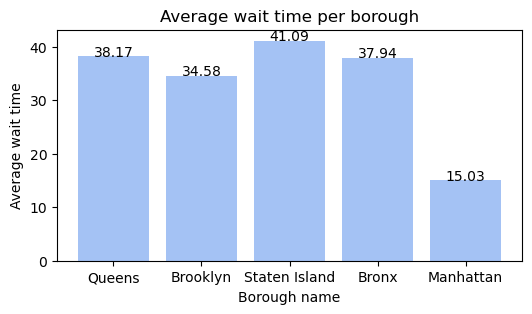

In [69]:
# Plotting the query2
pandas_query2_df = avg_wait_time_per_borough.toPandas()

fig = plt.figure(figsize = (6, 3))

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

x = pandas_query2_df.get("borough")
y = pandas_query2_df.get("avg_waiting_time")
# creating the bar plot
plt.bar(x, y, color ='#a4c2f4ff')

addlabels(x, y)
plt.xlabel("Borough name")
plt.ylabel("Average wait time")
plt.title("Average wait time per borough")
plt.show()

## Query 3: Trips started in one borough

The number of trips that started and ended within the same borough,


In [59]:
same_borough_df = taxiDataDf_with_boroughs.filter(F.col("startBoroughIndex") == F.col("endBoroughIndex"))
print("The number of trips that start and end in the same borough is " + str(same_borough_df.count()) + ".")

The number of trips that start and end in the same borough is 87930.


In [68]:
grouped_query3_df = same_borough_df.groupBy("startBoroughIndex").count()

#Creating new column 'row_id'
grouped_query3_df = grouped_query3_df.withColumn("row_id", F.col("startBoroughIndex"))

# Joining it together to get borough names
grouped_query3_df_with_names = grouped_query3_df.join(borough_df_sorted, "row_id", "inner")

# Finding 
query3_df = grouped_query3_df_with_names.groupBy("borough").sum('count')
query3_df.show()

+-------------+----------+
|      borough|sum(count)|
+-------------+----------+
|       Queens|      3147|
|     Brooklyn|      1069|
|Staten Island|        17|
|        Bronx|        55|
|    Manhattan|     83642|
+-------------+----------+



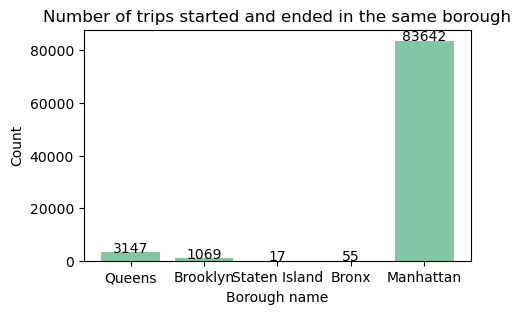

In [73]:
# Plotting the query3 results

query3_df_pandas = query3_df.toPandas()

fig = plt.figure(figsize = (5, 3))

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

x = query3_df_pandas.get("borough")
y = query3_df_pandas.get("sum(count)")
# creating the bar plot
plt.bar(x, y, color ='#82c7a5ff')

addlabels(x, y)
plt.xlabel("Borough name")
plt.ylabel("Count")
plt.title("Number of trips started and ended in the same borough")
plt.show()

## Query 4: Trips between different boroughs

The number of trips that started in one borough and ended in another one

In [75]:
different_borough_df = taxiDataDf_with_boroughs.filter(F.col("startBoroughIndex") != F.col("endBoroughIndex"))
print("The number of trips that have different start and end borough is " + str(different_borough_df.count()) + ".")

The number of trips that have different start and end borough is 12069.


### Plots: start borough

In [83]:
grouped_query4_start_df = different_borough_df.groupBy("startBoroughIndex").count()

#Creating new column 'row_id'
grouped_query4_start_df = grouped_query4_start_df.withColumn("row_id", F.col("startBoroughIndex"))

# Joining it together to get borough names
grouped_query4_start_df_with_names = grouped_query4_start_df.join(borough_df_sorted, "row_id", "inner")

# Finding 
query4_start_df = grouped_query4_start_df_with_names.groupBy("borough").sum('count')
query4_start_df.show()

+-------------+----------+
|      borough|sum(count)|
+-------------+----------+
|       Queens|      4563|
|     Brooklyn|       901|
|Staten Island|        10|
|        Bronx|        38|
|    Manhattan|      6557|
+-------------+----------+



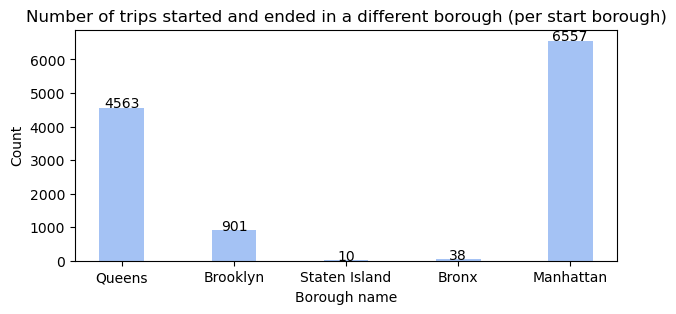

In [89]:
# Plotting the query4 results (start borough)

query4_start_df_pandas = query4_start_df.toPandas()

fig = plt.figure(figsize = (7, 3))

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

x = query4_start_df_pandas.get("borough")
y = query4_start_df_pandas.get("sum(count)")
# creating the bar plot
plt.bar(x, y, color ='#a4c2f4ff', width=0.4)

addlabels(x, y)
plt.xlabel("Borough name")
plt.ylabel("Count")
plt.title("Number of trips started and ended in a different borough (per start borough)")
plt.show()

### Plots: end borough

In [85]:
grouped_query4_end_df = different_borough_df.groupBy("endBoroughIndex").count()

#Creating new column 'row_id'
grouped_query4_end_df = grouped_query4_end_df.withColumn("row_id", F.col("endBoroughIndex"))

# Joining it together to get borough names
grouped_query4_end_df_with_names = grouped_query4_end_df.join(borough_df_sorted, "row_id", "inner")

# Finding 
query4_end_df = grouped_query4_end_df_with_names.groupBy("borough").sum('count')
query4_end_df.show()

+-------------+----------+
|      borough|sum(count)|
+-------------+----------+
|       Queens|      4297|
|     Brooklyn|      2535|
|Staten Island|       220|
|        Bronx|       368|
|    Manhattan|      4649|
+-------------+----------+



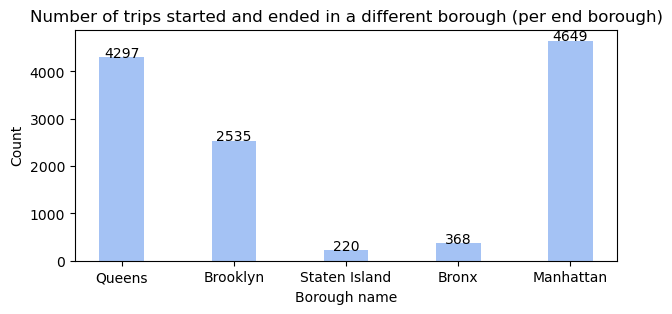

In [88]:
# Plotting the query4 results (start borough)

query4_end_df_pandas = query4_end_df.toPandas()

fig = plt.figure(figsize = (7, 3))

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

x = query4_end_df_pandas.get("borough")
y = query4_end_df_pandas.get("sum(count)")
# creating the bar plot
plt.bar(x, y, color ='#a4c2f4ff', width=0.4)

addlabels(x, y)
plt.xlabel("Borough name")
plt.ylabel("Count")
plt.title("Number of trips started and ended in a different borough (per end borough)")
plt.show()